In [2]:
!pip install -q lucid>=0.2.3

In [3]:
import numpy as np
import math

import ctypes.util
from lucid.misc.gl.glcontext import create_opengl_context

from IPython.display import display
from PIL import Image
import time
from IPython.display import clear_output

# Now it's safe to import OpenGL and EGL functions
import OpenGL.GL as gl
from OpenGL.GLU import *

# create_opengl_context() creates GL context that is attached to an
# offscreen surface of specified size. Note that rendering to buffers
# of different size and format is still possible with OpenGL Framebuffers.
#
# Users are expected to directly use EGL calls in case more advanced
# context management is required.
WIDTH, HEIGHT = 1000,800
create_opengl_context((WIDTH, HEIGHT))
    
# OpenGL context is available here.

print(gl.glGetString(gl.GL_VERSION))
print(gl.glGetString(gl.GL_VENDOR)) 
#print(gl.glGetString(gl.GL_EXTENSIONS))

b'4.6.0 NVIDIA 460.32.03'
b'NVIDIA Corporation'


In [4]:
#ZoneFinder
def findZone(x1, y1, x2, y2):
  z = None

  dy = y2 - y1
  dx = x2 - x1
  
  if dy < 0:
    dyMod = dy * (-1)
  else:
    dyMod = dy
  if dx < 0:
    dxMod = dx * (-1)
  else:
    dxMod = dx
  
  if dx >= 0 and dy >= 0:     #1st quadrant
    if dxMod > dyMod:
      z = 0
    else:
      z = 1
  elif dx < 0 and dy >= 0:   #2nd quadrant
    if dyMod > dxMod:
      z = 2
    else:
      z = 3
  elif dx < 0 and dy < 0:   #3rd quadrant
    if dxMod > dyMod:
      z = 4
    else:
      z = 5
  elif dx >= 0 and dy < 0:   #4th quadrant
    if dyMod > dxMod:
      z = 6
    else:
      z = 7
  return z


#Zone-M to Zone-0 convert
def convertMto0(zone, x, y):

  if zone == 1:
    xi = y
    yi = x
  
  elif zone == 2:
    xi = y
    yi = x * (-1)

  elif zone == 3:
    xi = x * (-1)
    yi = y
  
  elif zone == 4:
    xi = x * (-1)
    yi = y * (-1)

  elif zone == 5:
    xi = y * (-1)
    yi = x * (-1)

  elif zone == 6:
    xi = y * (-1)
    yi = x

  else:
    xi = x
    yi = y * (-1)
  
  return [xi, yi]


#Zone-0 to Zone-M convert
def convert0toM(zone, x, y):   #m refers to the original zone

  if zone == 1:
    xi = y
    yi = x
  
  elif zone == 2:
    xi = y * (-1)
    yi = x

  elif zone == 3:
    xi = x * (-1)
    yi = y
  
  elif zone == 4:
    xi = x * (-1)
    yi = y * (-1)

  elif zone == 5:
    xi = y * (-1)
    yi = x * (-1)

  elif zone == 6:
    xi = y
    yi = x * (-1)

  else:
    xi = x
    yi = y * (-1)
  
  return [xi, yi]


#Zone-0 Midpoint Line Algo
def midpointLineAlgo(x1,y1,x2,y2):
  dy = y2 - y1
  dx = x2 - x1
  d = 2*dy - dx
  incE = 2*dy
  incNE = 2 * (dy - dx)
  p = [[x1, y1]]    #pixels needed to create the line
  selected = [x1, y1]
  while selected[0] < x2 or selected[1] < y2:
    if d > 0:   #NE
      selected[0] = selected[0] + 1
      selected[1] = selected[1] + 1
      p.append(selected.copy())
      d = d + incNE
    else:     #E
      selected[0] = selected[0] + 1
      p.append(selected.copy())
      d = d + incE
    
  return p



#Zone-M Midpoint Line Algo
def m_midpointLineAlgo(x1,y1,x2,y2):   #Finalized Midpoint Line Algo Function
  zone = findZone(x1, y1, x2, y2)
  
  if zone == 0:
    pixels = midpointLineAlgo(x1,y1,x2,y2)
  
  else:
    newEnd1 = convertMto0(zone, x1, y1)    #newEnd1 and newEnd2 are converted Zone-0 endpoints
    newEnd2 = convertMto0(zone, x2, y2)
    pixels = midpointLineAlgo(newEnd1[0], newEnd1[1], newEnd2[0], newEnd2[1])
    
    numOfPixels = len(pixels)
    i = 0
    while i < numOfPixels:
      pixels[i] = convert0toM(zone, pixels[i][0], pixels[i][1])
      i += 1
  
  return pixels

In [5]:
#Zone-1 Circle
def z1_zone(r, h, k):
  d = 1 - r
  selected_x = 0
  selected_y = r
  
  z1_pixels = [[selected_x, selected_y]]
  while selected_x <= selected_y: 
    if d >= 0:  #SE
      d = d + 2*selected_x - 2*selected_y + 5
      selected_x = selected_x + 1
      selected_y = selected_y - 1
      z1_pixels.append([selected_x, selected_y])
    else:       #E
      d = d + 2*selected_x + 3
      selected_x = selected_x + 1
      z1_pixels.append([selected_x, selected_y])
    
    
  return z1_pixels


    
#Other Zones
def o_zones(z1_pixels):
  l = len(z1_pixels)
  z0_pixels = []
  i = 0
  while i < l:
    z0_pixels.append([z1_pixels[i][1], z1_pixels[i][0]])
    i += 1
  

  z2_pixels = []
  i = 0
  while i < l:
    z2_pixels.append([-1 * z1_pixels[i][0], z1_pixels[i][1]])
    i += 1
  
  z3_pixels = []
  i = 0
  while i < l:
    z3_pixels.append([-1 * z1_pixels[i][1], z1_pixels[i][0]])
    i += 1
  
  z4_pixels = []
  i = 0
  while i < l:
    z4_pixels.append([-1 * z1_pixels[i][1], -1 * z1_pixels[i][0]])
    i += 1
  
  z5_pixels = []
  i = 0
  while i < l:
    z5_pixels.append([-1 * z1_pixels[i][0], -1 * z1_pixels[i][1]])
    i += 1

  z6_pixels = []
  i = 0
  while i < l:
    z6_pixels.append([z1_pixels[i][0], -1 * z1_pixels[i][1]])
    i += 1
  
  z7_pixels = []
  i = 0
  while i < l:
    z7_pixels.append([z1_pixels[i][1], -1 * z1_pixels[i][0]])
    i += 1
  
  o_pixels = z0_pixels + z2_pixels + z3_pixels + z4_pixels + z5_pixels + z6_pixels + z7_pixels

  return o_pixels



#Circle
def midpointCircleAlgo(r, h, k):       #Finalized Midpoint Circle Algo Function
  z1_pixels = z1_zone(r, h, k)
  o_pixels = o_zones(z1_pixels)
  pixels = z1_pixels + o_pixels
  if h == 0 and k == 0:
    return pixels
  
  else:
    i = 0
    while i < len(pixels):
      pixels[i] = [pixels[i][0] + h, pixels[i][1] + k]
      i += 1
    return pixels

In [6]:
#Transformation-Translation- for a set of points
def translate(s, a, b, c, d, e, f):   #x_prime = ax + by + c; y_prime = dx + ey + f
  s_translated = []
  t = np.array([[a, b, c],
                [d, e, f],
                [0, 0, 1]])
  
  i = 0
  while i < len(s):
    p = np.array([[s[i][0]],
                  [s[i][1]],
                  [1]])
    
    p_prime = np.matmul(t, p)
    s_translated.append([p_prime[0][0], p_prime[1][0]])
    i += 1
  
  return s_translated


#Transformation-Scaling- for a set of points
def scale(s, sc_x, sc_y):   #x_prime = sc_x * x; y_prime = sc_y * y
  s_scaled = []
  sc = np.array([[sc_x, 0, 0],
                [0, sc_y, 0],
                [0, 0, 1]])
  
  i = 0
  while i < len(s):
    p = np.array([[s[i][0]],
                  [s[i][1]],
                  [1]])
    
    p_prime = np.matmul(sc, p)
    s_scaled.append([p_prime[0][0], p_prime[1][0]])
    i += 1
  
  return s_scaled


#Transformation-Rotation- for a set of points
def rotate(s, angle):                     #x_prime = x*cos(angle) - y*sin(angle); y_prime = x*sin(angle) + y*cos(angle); angle:degrees
  cosine = math.cos(math.radians(angle))
  sine = math.sin(math.radians(angle))
  s_rotated = []
  r = np.array([[cosine, -1 * sine, 0],
                [sine, cosine, 0],
                [0, 0, 1]])
  
  i = 0
  while i < len(s):
    p = np.array([[s[i][0]],
                  [s[i][1]],
                  [1]])
    
    p_prime = np.matmul(r, p)
    s_rotated.append([p_prime[0][0], p_prime[1][0]])
    i += 1
  
  return s_rotated

In [7]:
#stickman Movements & Bound Handling
def moveLeftWalk(s):
  stickman_transformed = translate(s,1,0,-80,0,1,0)

  return stickman_transformed


def moveRightWalk(s):
  stickman_transformed = translate(s,1,0,80,0,1,0)

  return stickman_transformed
  

def moveUpWalk(s):
  stickman_transformed = translate(s,1,0,0,0,1,120)
  stickman_transformed = scale(stickman_transformed, 10/11, 10/11)

  return stickman_transformed


def moveDownWalk(s):
  stickman_transformed = translate(s,1,0,0,0,1,-120) 
  stickman_transformed = scale(stickman_transformed, 1.1, 1.1)
  
  return stickman_transformed


def boundExceed(s):
  stickman_transformed = rotate(s,45)

  return stickman_transformed


In [8]:
#midpointstick
def initial_stickman():

  vertex=[-30,160,-20,120]    #leftHand1
  stickman = m_midpointLineAlgo(vertex[0],vertex[1],vertex[2],vertex[3])
  vertex=[0,110,-20,120]     #leftHand2
  stickman += m_midpointLineAlgo(vertex[0],vertex[1],vertex[2],vertex[3])
  vertex=[30,160,20,120]   #rightHand1
  stickman += m_midpointLineAlgo(vertex[0],vertex[1],vertex[2],vertex[3])
  vertex=[20,120,0,110]    #rightHand2
  stickman += m_midpointLineAlgo(vertex[0],vertex[1],vertex[2],vertex[3])
  vertex=[0,130,0,80]     #midline
  stickman += m_midpointLineAlgo(vertex[0],vertex[1],vertex[2],vertex[3])
  vertex=[0,80,-20,70]     #leftLeg1
  stickman += m_midpointLineAlgo(vertex[0],vertex[1],vertex[2],vertex[3])
  vertex=[-20,30,-20,70]    #leftLeg2
  stickman += m_midpointLineAlgo(vertex[0],vertex[1],vertex[2],vertex[3])
  vertex=[0,80,20,70]     #rightLeg1
  stickman += m_midpointLineAlgo(vertex[0],vertex[1],vertex[2],vertex[3])
  vertex=[20,70,20,30]     #rightLeg2
  stickman += m_midpointLineAlgo(vertex[0],vertex[1],vertex[2],vertex[3])
  vertex=[10,0,140]        #head
  stickman += midpointCircleAlgo(vertex[0],vertex[1],vertex[2])

  return stickman



In [9]:
def output(stickman):
  gl.glClear(gl.GL_COLOR_BUFFER_BIT)
  gl.glColor3f(.5, .3, .7)
  gl.glPointSize(5)
  gl.glBegin(gl.GL_POINTS)
  i = 0
  while i < len(stickman):
    gl.glVertex2f(stickman[i][0]/500, stickman[i][1]/400)
    i += 1

  gl.glEnd()

  img_buf = gl.glReadPixelsub(0, 0, WIDTH, HEIGHT, gl.GL_RGB, gl.GL_UNSIGNED_BYTE)
  img = np.frombuffer(img_buf,np.uint8).reshape(HEIGHT, WIDTH, 3)[::-1]
  display(Image.fromarray(img,'RGB'))

def outputBoundExceed(stickman):
  gl.glClear(gl.GL_COLOR_BUFFER_BIT)
  gl.glColor3f(1, 0, 0)
  gl.glPointSize(5)
  gl.glBegin(gl.GL_POINTS)
  i = 0
  while i < len(stickman):
    gl.glVertex2f(stickman[i][0]/500, stickman[i][1]/400)
    i += 1

  gl.glEnd()

  img_buf = gl.glReadPixelsub(0, 0, WIDTH, HEIGHT, gl.GL_RGB, gl.GL_UNSIGNED_BYTE)
  img = np.frombuffer(img_buf,np.uint8).reshape(HEIGHT, WIDTH, 3)[::-1]
  display(Image.fromarray(img,'RGB'))



In [19]:
#Initialization
stickman = initial_stickman()    #Initial Stickman pixels.
lrBlockState = 0    #State Values range between -4 to 4. for left/down: decrease & for right/up: increase
udBlockState = 0

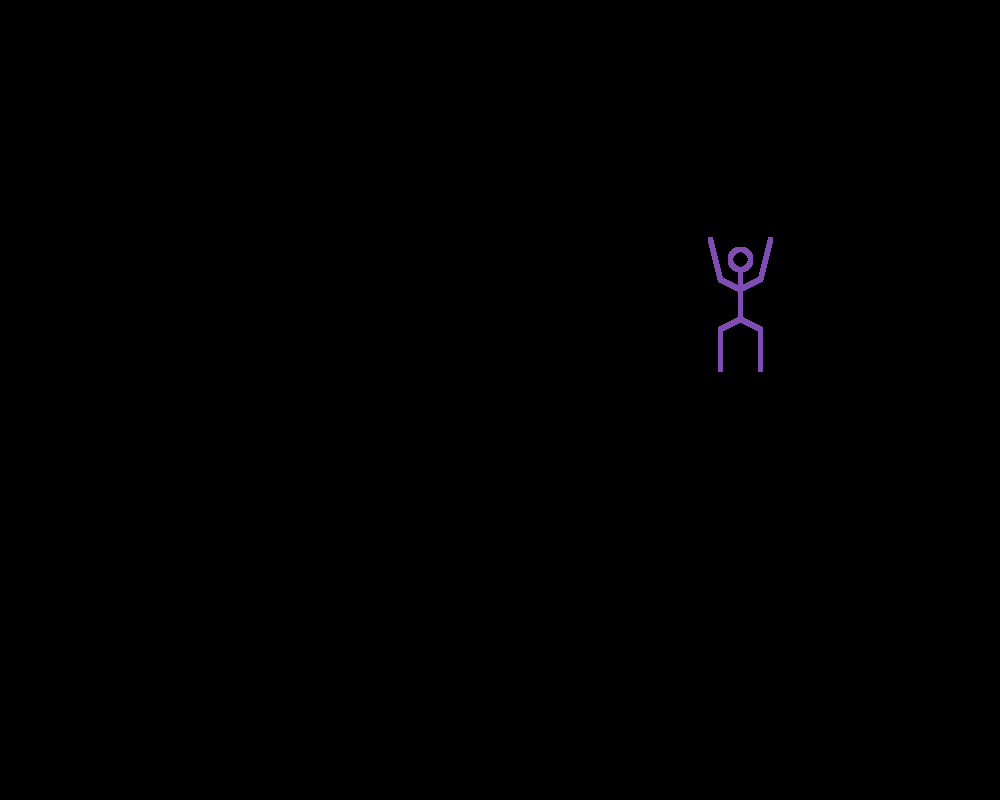

In [21]:
#Interprating User Input

direction = input("Which Direction(Left / Right / Up / Down):")
amount = int(input("How Many:"))

time.sleep(3)
clear_output()
time.sleep(2)
output(stickman)



if direction == "Left" or direction == "left":
  isPossible = lrBlockState - amount
  if isPossible >= -4:
    i = 1
    while i <= amount:
      stickman = moveLeftWalk(stickman)
      lrBlockState -= 1

      time.sleep(3)
      clear_output()
      time.sleep(2)
      output(stickman)
      i += 1
  else:
    time.sleep(3)
    clear_output()
    time.sleep(2)
    outputBoundExceed(boundExceed(stickman))
    time.sleep(3)
    clear_output()
    time.sleep(2)
    output(stickman)


  
elif direction == "Right" or direction == "right":
  isPossible = lrBlockState + amount
  if isPossible <= 4:
    i = 1
    while i <= amount:
      stickman = moveRightWalk(stickman)
      lrBlockState += 1

      time.sleep(3)
      clear_output()
      time.sleep(2)
      output(stickman)
      i += 1
  else:
    time.sleep(3)
    clear_output()
    time.sleep(2)
    outputBoundExceed(boundExceed(stickman))
    time.sleep(3)
    clear_output()
    time.sleep(2)
    output(stickman)
  

elif direction == "Up" or direction == "up":
  isPossible = udBlockState + amount
  if isPossible <= 4:
    i = 1
    while i <= amount:
      stickman = moveUpWalk(stickman)
      udBlockState += 1

      time.sleep(3)
      clear_output()
      time.sleep(2)
      output(stickman)
      i += 1
  else:
    time.sleep(3)
    clear_output()
    time.sleep(2)
    outputBoundExceed(boundExceed(stickman))
    time.sleep(3)
    clear_output()
    time.sleep(2)
    output(stickman)
  
    
elif direction == "Down" or direction == "down":
  isPossible = udBlockState - amount
  if isPossible >= -4:
    i = 1
    while i <= amount:
      stickman = moveDownWalk(stickman)
      udBlockState -= 1

      time.sleep(3)
      clear_output()
      time.sleep(2)
      output(stickman)
      i += 1
  else:
    time.sleep(3)
    clear_output()
    time.sleep(2)
    outputBoundExceed(boundExceed(stickman))
    time.sleep(3)
    clear_output()
    time.sleep(2)
    output(stickman)

else:
  print("direction doesn't exist")